In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [0]:
#### Base name
def RomanToNumber(string):
    string = str(string)
    roman_dict = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6, 'VII': 7, 'VIII': 8, 'IX': 9, 'X': 10}
    char_list = string.split(' ')
    new_name_list = []
    for char in char_list:
        if char in roman_dict:
            new_name_list += [str(roman_dict[char])]
        else:
            new_name_list += [char]
    return ' '.join(new_name_list)

## Pre-Processing

In [0]:
data = pd.read_csv('data/vgsales-12-4-2019.csv')
data_filter = data[data['Year'] < 2020.0]
data_filter = data_filter[data_filter['Year'] >= 2010.0]
data_filter = data_filter[data_filter['Global_Sales'] != 0]
data_filter = data_filter[data_filter['Global_Sales'].notna()]
select_column = ['Name', 'Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Critic_Score', 'Global_Sales', 'Year']
select_data = data_filter.loc[:, select_column]
select_data['Global_Sales'] = select_data['Global_Sales']*0.81
select_data['base_name'] = select_data.Name.replace('[^a-zA-Z0-9_ -]', '', regex=True) 
select_data['base_name'] = select_data[['base_name']].applymap(RomanToNumber)
select_data['base_name'] = select_data.base_name.replace('[- +]', '_', regex=True).str.lower() 

### Deal with *Publisher*

In [0]:
table = select_data.groupby(['Publisher','Name']).size().reset_index()
publisher_table = table.groupby('Publisher').size().reset_index()
publisher_table = publisher_table.rename(columns={0: "Count"})
conditions = [
  publisher_table['Count'] <= 50,
  (publisher_table['Count'] > 50) & (publisher_table['Count'] <= 100),
  (publisher_table['Count'] > 100), 
]
choices = ['Small', 'Medium', 'Large']
publisher_table['Company_Size'] = np.select(conditions, choices, default = "No")
# Join the publisher table with select_data
select_data = select_data.merge(publisher_table, on='Publisher', how='left')
select_data = select_data.drop(columns=['Count', 'Publisher'])

### Genre

In [0]:
#### Genre
select_data.groupby('Genre').count() 
genre_ex_list = ['Board Game', 'Education', 'Sandbox'] #delete 'Board Game', 'Education', 'Sandbox'
select_data = select_data[~select_data.Genre.isin(genre_ex_list)]

### ESBR Rating

In [0]:
#### Group ESBR Rating
conditions = [
    select_data.ESRB_Rating.isin(['EC','E','E10']),
    select_data['ESRB_Rating'] == 'T',
    select_data['ESRB_Rating'] == 'M',
    (select_data['ESRB_Rating'] == 'RP') | (select_data['ESRB_Rating'].isna())
]
choices = ['Level1', 'Level2', 'Level3','Level4']
select_data['ESRB_Rating'] = np.select(conditions, choices, default = "No")

### Add Price

In [0]:
price_df = pd.read_csv('data/price-guide.csv')

# Change console name to our data standard
conditions = [
  price_df['console-name'] == 'Nintendo 3DS',
  price_df['console-name'] == 'Nintendo DS',
  price_df['console-name'] == 'Nintendo Switch', 
  price_df['console-name'] == 'PSP',
  price_df['console-name'] == 'Playstation 2',
  price_df['console-name'] == 'Playstation 3',
  price_df['console-name'] == 'Playstation 4',
  price_df['console-name'] == 'Playstation Vita',
  price_df['console-name'] == 'Wii',
  price_df['console-name'] == 'Wii U',
  price_df['console-name'] == 'Xbox',
  price_df['console-name'] == 'Xbox 360',
  price_df['console-name'] == 'Xbox One'
]
choices = ['3DS', 'DS', 'NS', 'PSP', 'PS2', 'PS3', 'PS4', 
           'PSV', 'Wii', 'WiiU', 'X360', 'X360', 'XOne']
price_df['Platform'] = np.select(conditions, choices, default = "No")
price_df = price_df.rename(columns={'product-name': 'Name'})

# Filter the name that contains []
price_df = price_df[~price_df['Name'].str.contains("\[")]

In [0]:
price_df['base_name'] = price_df.Name.replace('[^a-zA-Z0-9_ -]', '', regex=True) 
price_df['base_name'] = price_df[['base_name']].applymap(RomanToNumber)
price_df['base_name'] = price_df.base_name.replace('[- +]', '_', regex=True).str.lower()
select_data = select_data.merge(price_df, on=['base_name','Platform'], how='left')
select_data = select_data.drop(columns = ['Name_x', 'id', 'console-name', 'Name_y'])
select_data = select_data.rename(columns = {"new-price": "Price"})
select_data['Price'] = select_data['Price'].str.replace('$', '')
select_data['Price'] = select_data['Price'].astype(float)

### Add Critic Score

In [185]:
#### new score data
tidytuesday = pd.read_csv('data/video_games.csv')
tidytuesday['Critic_Score_new'] = tidytuesday['metascore']/10
tidytuesday = tidytuesday[tidytuesday['Critic_Score_new'].notna()]
score_data = tidytuesday[['game','Critic_Score_new']]
score_data['base_name'] = score_data.game.replace('[^a-zA-Z0-9_ -]', '', regex=True) 
score_data['base_name'] = score_data[['base_name']].applymap(RomanToNumber)
score_data['base_name'] = score_data.base_name.replace('[- +]', '_', regex=True).str.lower() 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [0]:
select_data = select_data.merge(score_data, on=['base_name'], how='left')
select_data['Critic_Score'] = select_data['Critic_Score'].where(~select_data.Critic_Score.isna(),select_data['Critic_Score_new'])

### if_not_score feature

In [0]:
select_data['if_not_score'] = select_data[['Critic_Score']].applymap(lambda x: 1 if pd.isnull(x) else 0)
select_data['Critic_Score'] = select_data[['Critic_Score']].applymap(lambda x: 0 if pd.isnull(x) else x)

### Platform

In [0]:
#### Platform
select_data.groupby('Platform').count() 
platform_ex_list = ['GBA', 'Mob', 'PSN','VC','XBL'] #delete 'GBA', 'Mob', 'PSN','VC','XBL'
select_data = select_data[~select_data.Platform.isin(platform_ex_list)]

In [0]:
#### Group Platform_new
conditions = [
    select_data['Platform'] == 'PC',
    select_data.Platform.isin(['PS2','PS3','PS4','Wii','WiiU','X360','XOne']),
    select_data.Platform.isin(['PSP','PSV','3DS','DS','NS'])
]
choices = ['PC', 'Game Console', 'Handheld']
select_data['Platform'] = np.select(conditions, choices, default = "No")

In [0]:
data_ws = select_data.groupby(['base_name','Genre','Company_Size','ESRB_Rating','Platform','if_not_score']).agg({'Global_Sales':'sum', 'Critic_Score':'mean', 'Price':'mean'}).reset_index()[['base_name','Genre','Company_Size','ESRB_Rating','Platform','Critic_Score','Global_Sales','Price','if_not_score']]

## Feature Engineering

### Imputing Price

In [0]:
#### imputing price
avg_genre_platform = data_ws.groupby(['Genre','Platform']).agg('mean').reset_index()[['Genre', 'Platform', 'Price']]
avg_genre = data_ws.groupby('Genre').agg('mean').reset_index()[['Genre','Price']].rename(columns = {'Price':'Price_g'})
avg_genre_platform = avg_genre_platform.merge(avg_genre, on=['Genre'], how='left')
avg_genre_platform['Price_t'] = avg_genre_platform['Price'].where(~avg_genre_platform.Price.isna(),avg_genre_platform['Price_g'])
avg_genre_platform = avg_genre_platform[['Genre','Platform','Price_t']]
data_wps = data_ws.merge(avg_genre_platform, on=['Genre','Platform'], how='left')
data_wps['Price'] = data_wps['Price'].where(~data_wps.Price.isna(), data_wps['Price_t'])
data_wps = data_wps.drop(columns=['Price_t'])

#### Output the raw data for UI

In [0]:
## save the data for app.py
data_wps.to_csv("data/data_v2_raw.csv", index=False, header=True)

### One-hot Encoder

In [0]:
def Categorical_Encoder(df, column_name = 'Company_Size'):
  temp_df = pd.get_dummies(df[column_name], prefix=column_name)
  df = pd.concat([df, temp_df], axis=1)
  return df

In [0]:
categorical_column = ['Company_Size', 'ESRB_Rating', 'Platform', 'Genre']
for column_name in categorical_column:
    data_wps = Categorical_Encoder(data_wps, column_name)
data = data_wps.drop(columns = ['Genre', 'Company_Size', 'ESRB_Rating', 'Platform'])

### Dealing with outliers

In [193]:
sales = data.Global_Sales.values
sales_95 = np.percentile(sales, 95)
sales_5 = np.percentile(sales, 5)
print("95% percentile of Global Sales is: ", sales_95)
print("5% percentile of Global Sales is: ", sales_5)

95% percentile of Global Sales is:  1.62
5% percentile of Global Sales is:  0.008100000000000001


In [0]:
for i in range(sales.shape[0]):
  if sales[i] > sales_95:
    sales[i] = sales_95
  elif sales[i] < sales_5:
    sales[i] = sales_5
  else:
    continue

In [0]:
data["Global_Sales"] = sales

#### output the processed data for modeling

In [0]:
### output the processed data for modeling
data.to_csv("data/data_v2.csv", index=False, header=True)

# Modeling

### Linear Regression

In [0]:
# Import packages for modeling here
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [0]:
# Read Data
# data = pd.read_csv("data.csv")

In [0]:
def SplitData(data):
  """Split training and testing set"""
  select_col_idx = [1] + [i for i in range(3, len(list(data)))]
  X = data.iloc[:, select_col_idx].values
  y = data.Global_Sales.values

  # Split train test data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

  return X_train, X_test, y_train, y_test

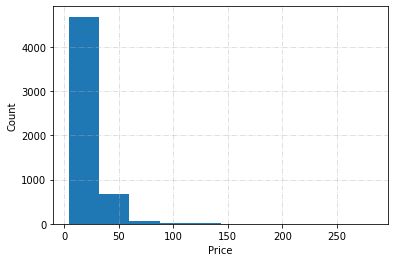

In [200]:
#check the distribution of numeric variable
plt.figure() 
x = data['Price']
plt.hist(x) 
plt.grid(alpha=0.5,linestyle='-.') 
plt.xlabel('Price')  
plt.ylabel('Count')  
plt.show()

In [0]:
data['Price_t'] = np.log(data['Price'])
data['Global_Sales'] = np.log(data['Global_Sales'])
data = data.drop(columns=['Price'])
#log transformation, to nearly normal distribution

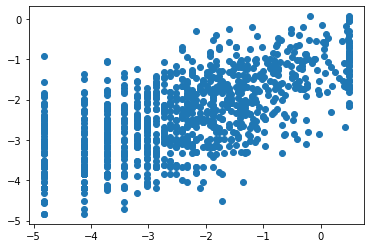

In [203]:
# start modeling
X_train, X_test, y_train, y_test = SplitData(data)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
plt.scatter(y_test,y_pred)

In [204]:
reg.score(X_test, y_test) #R2

0.46125553825762267

In [205]:
mean_squared_error(y_test, y_pred)

1.1796670615744294

### Random Forest

In [0]:
# data = pd.read_csv("data_v2.csv")
# data["Global_Sales"] = np.log(data["Global_Sales"])
# data["Price"] = np.log(data["Price"])

In [0]:
def trainRandomForestReg(X_train, X_test, y_train, y_test, args_dict, eval_method=mean_squared_error):
  """Training on Random Forest Regression on given arguments
    Arg:
      args_dict (dictionary): A dictionary of hyper-parameter used for tuning
  """
  regr = RandomForestRegressor(**args_dict)
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_test)
  score = eval_method(y_test, y_pred)

  return score, y_pred

In [0]:
def kFoldCV(X, y, args_dict, k=5):
  """Run k fold cross validation"""
  
  kf = KFold(n_splits=k)
  sum_score = 0
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    score, _ = trainRandomForestReg(X_train, X_test, y_train, y_test, args_dict)
    sum_score += score
  return sum_score / k

In [0]:
def fineTuneParameter(X, y):
  """Initialize the range of hyperparameter we want to tune"""

  # ===============================================================
  # Currently we consider fine tune on n_estimators, max_depth
  # n_estimators: number of trees
  # max_depth: The maximum depth of the tree
  # ===============================================================

  # Initialize with default value
  args_dict = {"n_estimators": 100, 
               "max_depth": None}
  min_score = 1000
  best_args_dict = args_dict

  # Initialize a result dictionary, key: args_dict, value: scores
  param_score = {}

  for n in range(100, 210, 10):
    for depth in [3, 4, 5, 6, 7, 8]:
      args_dict["n_estimators"] = n
      args_dict["max_depth"] = depth
      kfold_score = kFoldCV(X, y, args_dict)
      param_combin = "n_estimators: " + str(n) + " , max_depth: " + str(depth)
      param_score[param_combin] = kfold_score

      # Update best score and parameter combination
      if kfold_score < min_score:
        min_score, best_args_dict = kfold_score, args_dict
  
  return min_score, best_args_dict, param_score

In [0]:
# Start Random Forest Model
X_train, X_test, y_train, y_test = SplitData(data)

# Cross Validation on Training set
# min_score, best_args_dict, param_score = fineTuneParameter(X_train, y_train)

In [0]:
# Run Random Forest regression on best combination
best_args_dict = {'max_depth': 10, 'n_estimators': 200}
score, y_pred = trainRandomForestReg(X_train, X_test, y_train, y_test, best_args_dict)

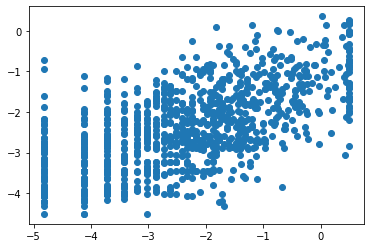

In [211]:
plt.scatter(y_test, y_pred)

In [212]:
mean_squared_error(y_test, y_pred)

1.1873339674406738

In [213]:
r2_score(y_test, y_pred)

0.4577541239953421

In [214]:
best_args_dict

{'max_depth': 10, 'n_estimators': 200}

# Save the model

In [215]:
import pickle
Pkl_Filename = "Random_Forest_Model.pkl"  


# Get the model
regr = RandomForestRegressor(**best_args_dict)
regr.fit(X_train, y_train)


# with open(Pkl_Filename, 'wb') as file:  
#     pickle.dump(regr, file)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)